In [1]:
%matplotlib inline
#load libraries
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier #baseline model
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeClassifier 

from IPython.display import display #displays full dataframe columns
#display all dataframe columns when printed
pd.options.display.max_columns = None

C:\tooling\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load data
df = pd.read_csv('C:/Users/Mark.Burghart/Documents/projects/hospice_carepoint/data/transformed/carepoint_transformed_dummied.csv', index_col=0)
df.shape

(271541, 120)

Need to still create building/holdout sets (80/20), cross validation of building set, impute missing values (set to 0 for now).
<br>
<br>
Pipeline todo: missing data, feature selection, grid search hyperparameter tuning, model training.
<br><br>
pipe flow: Fill in missing data, feature selection, model training and tuning via grid search. 



### Train/Test Split


In [3]:
#separate variables (X) from outcome of interest (y)
df.shape
cols = df.columns.get_values() #converts column names to list
cols = cols.tolist()
feature_cols = [x for x in cols if x != 'death_within_7_days'] #removes outcome of interest from list ('death_within_7_days')

#extract rows
#print(feature_cols) #debug
X = df.loc[:, feature_cols]
X.shape #outcome column has been removed

(271541, 119)

In [4]:
#save outcome variable as y
y = df.death_within_7_days
y.shape

(271541,)

In [5]:
#separate data into training/test (aka holdout) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 23) #random_state for reproducibility (if needed)
#X_test, y_test should not be used until NO MORE decisions are being made. This is the final, FINAL validation, and more often just used for model performance and generalizability!

<br> 
# Pipepline for imputation, feature selection, and model training/tuning<br><br>
#### Logistic Regression with L1 Lasso Penalty, imputation = Median columnar value


First up: Logistic Regression models. Going to try both L1 and L2 Regularization.<br><br>
Note: For *MISSING DATA*,  I am **IMPUTING THE MEDIAN COLUMN VALUE**, as opposed to setting to 0, or kNN imputation as of now.

In [6]:
kbest = SelectKBest(f_classif) #select best 'k' features
logreg = LogisticRegression(penalty = 'l1', random_state = 0) #L1 Regularization
impute = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0) #impute missing values: replacing NaNs with Median Column value for each column

#Pipeline for Logistic Regression with L1 Lasso Regularization
pipe_lr_l1 = Pipeline([('imputer', impute),
                       ('kbest', kbest),
                      ('lr', logreg)])

In [7]:
#parameters for grid search cross validation 
parameters = {'kbest__k': [5, 10, 20,40, 60], #building models with 40, 60, 80, and 100 most significant variables
                 'lr__C' : [0.01, 0.1, 1, 10, 100]} #tuning C for logistic regression

In [8]:
#grid search
grid = GridSearchCV(pipe_lr_l1, parameters, cv = 5, scoring = 'roc_auc') #run grid on parameters, 5-fold cross validation, AUC is evaluation metric

In [9]:
%%time
#fit models
grid.fit(X_train,y_train)


C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\fe

Wall time: 41min 21s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001D758DF30D0>)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest__k': [5, 10, 20, 40, 60], 'lr__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Model interpretations:<br><br>
feature [86] is constant, meaning the value is constant for all visits and patients (and should be removed from model).<br><br>
true_divide warning is likely due to feature[86], and is trying to divide by 0 variance...



In [10]:
print("Best estimator:\n{}".format(grid.best_estimator_)) #prints best model and pipeline
print("Logistic Regression step:\n{}".format(grid.best_estimator_.named_steps["lr"])) #prints logistic regression step of pipeline
print("Logistic Regression coefficients:\n{}".format(grid.best_estimator_.named_steps["lr"].coef_)) #prints coefficients of best estimator
print("Best Parameters: {}".format(grid.best_params_)) #outputs best parameters settings
print("Best cross validation score: {:.2f}".format(grid.best_score_)) #best produced cross validation score

Best estimator:
Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kbest', SelectKBest(k=60, score_func=<function f_classif at 0x000001D758DF30D0>)), ('lr', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Logistic Regression step:
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression coefficients:
[[ 9.52683832e-04 -1.32666922e-01  1.19567914e-01  1.69686820e-01
  -1.01592255e-02  9.30324824e-02  5.69836653e-02  9.69037316e-02
  -4.59095858e-03  4.14169229e-02  1.53879735e

In [11]:
#AUC scores for each training set run
print("Grid scores on training set: ")
means = grid.cv_results_['mean_train_score']
stds = grid.cv_results_['std_train_score']

for mean, std, params in zip(means, stds, grid.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))
    
#AUC scores for each validation set run
print("Grid scores on Development set: ")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

Grid scores on training set: 
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 0.01}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 0.1}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 1}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 10}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 100}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 0.01}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 0.1}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 1}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 10}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 100}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 0.01}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 0.1}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 1}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 10}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 100}
0.807 (+/-0.000) for {'kbest__k': 40, 'lr__C': 0.01}
0.808 (+/-0.000) for {'kbest__k': 40, 'lr__C': 0.1}
0.808 (+/-0.000) for {'kbest__k': 40, 'lr__C': 1}
0.808 (+/-0.000) for {'kbest__k': 40, 'lr__C':

C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [12]:
#return variables of significance
#start with 40
fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=0)
imputed_X_train = pd.DataFrame(fill_NaN.fit_transform(X_train))
imputed_X_train.columns = X_train.columns
imputed_X_train.index = X_train.index

#display columns...

In [13]:
#return variables of significance
#Return 100 features used in best model
selector = SelectKBest(f_classif, k = 100)
selector.fit(imputed_X_train, y_train)
features = imputed_X_train.columns[selector.get_support()]
print(features)
scores = selector.scores_ #saves scores of features
print(scores)

Index(['gender', 'Anxiety', 'Depression', 'Drowsiness', 'Lack_of_Appetite',
       'Nausea', 'Pain', 'Shortness_of_Breath', 'Tiredness', 'Wellbeing',
       'LengthOfCare_days', '3_visit_max_anxiety', '3_visit_max_depression',
       '3_visit_max_drowsiness', '3_visit_max_lackofappetite',
       '3_visit_max_nausea', '3_visit_max_pain',
       '3_visit_max_shortnessofbreath', '3_visit_max_tiredness',
       '3_visit_max_wellbeing', '5_visit_max_anxiety',
       '5_visit_max_depression', '5_visit_max_drowsiness',
       '5_visit_max_lackofappetite', '5_visit_max_nausea', '5_visit_max_pain',
       '5_visit_max_shortnessofbreath', '5_visit_max_tiredness',
       '5_visit_max_wellbeing', '3_visit_mean_anxiety',
       '3_visit_mean_depression', '3_visit_mean_drowsiness',
       '3_visit_mean_lackofappetite', '3_visit_mean_nausea',
       '3_visit_mean_pain', '3_visit_mean_shortnessofbreath',
       '3_visit_mean_tiredness', '3_visit_mean_wellbeing',
       '5_visit_mean_depression', '5_vi

**Logistic Regression with L1 penalty and median missing data imputation** <br><br>
- Best model selected used parameters K = 100 (100 variables included), and C = 1 for LogReg model. 
- AUC scores ranged from 0.807 (40 variables, C = 0.01-100) to 0.817

#### Logistic Regression with L2 Ridge Penalty, imputation = Median columnar value

In [14]:
#Logistic regression with L2 Regularization penalty
kbest = SelectKBest(f_classif) #select best 'k' features
logreg_l2 = LogisticRegression(penalty = 'l2', random_state = 0) #L2 Ridge Regularization
impute = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0) #impute missing values: replacing NaNs with Median Column value for each column

#Pipeline for Logistic Regression with L2 'Ridge' Regularization
pipe_lr_l2 = Pipeline([('imputer', impute),
                       ('kbest', kbest),
                      ('lr', logreg_l2)])
#parameters for grid search cross validation 
parameters = {'kbest__k': [5, 10, 20, 40, 60], #building models with 40, 60, 80, and 100 most significant variables
                 'lr__C' : [0.01, 0.1, 1, 10, 100]} #tuning C for logistic regression

#grid search
grid_l2 = GridSearchCV(pipe_lr_l2, parameters, cv = 5, scoring = 'roc_auc') #run grid on parameters, 5-fold cross validation, AUC is evaluation metric



In [15]:
%%time
#fit models
grid_l2.fit(X_train,y_train)

C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\fe

Wall time: 19min 15s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001D758DF30D0>)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest__k': [5, 10, 20, 40, 60], 'lr__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [16]:
print("Best estimator:\n{}".format(grid_l2.best_estimator_)) #prints best model and pipeline
print("Logistic Regression step:\n{}".format(grid_l2.best_estimator_.named_steps["lr"])) #prints logistic regression step of pipeline
print("Logistic Regression coefficients:\n{}".format(grid_l2.best_estimator_.named_steps["lr"].coef_)) #prints coefficients of best estimator
print("Best Parameters: {}".format(grid_l2.best_params_)) #outputs best parameters settings
print("Best cross validation score: {:.2f}".format(grid_l2.best_score_)) #best produced cross validation score

Best estimator:
Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kbest', SelectKBest(k=60, score_func=<function f_classif at 0x000001D758DF30D0>)), ('lr', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Logistic Regression step:
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression coefficients:
[[ 8.48669711e-04 -1.32466987e-01  1.19507325e-01  1.69695960e-01
  -1.00971379e-02  9.30824113e-02  5.72070777e-02  9.71376716e-02
  -4.58782396e-03  4.17210402e-02  1.53928058e-0

In [17]:
#AUC scores for each training set run
print("Grid scores on Development set: ")
means = grid.cv_results_['mean_train_score']
stds = grid.cv_results_['std_train_score']

for mean, std, params in zip(means, stds, grid.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

#AUC scores for each validation set run
print("Grid scores on Development set: ")
means = grid_l2.cv_results_['mean_test_score']
stds = grid_l2.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid_l2.cv_results_['params']): #note imbedded grid_l2 will need to be adjusted to correct object
    print("%0.3f (+/-%0.3f) for %r"
         % (mean, std *2, params))

Grid scores on Development set: 
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 0.01}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 0.1}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 1}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 10}
0.753 (+/-0.001) for {'kbest__k': 5, 'lr__C': 100}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 0.01}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 0.1}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 1}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 10}
0.766 (+/-0.001) for {'kbest__k': 10, 'lr__C': 100}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 0.01}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 0.1}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 1}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 10}
0.787 (+/-0.001) for {'kbest__k': 20, 'lr__C': 100}
0.807 (+/-0.000) for {'kbest__k': 40, 'lr__C': 0.01}
0.808 (+/-0.000) for {'kbest__k': 40, 'lr__C': 0.1}
0.808 (+/-0.000) for {'kbest__k': 40, 'lr__C': 1}
0.808 (+/-0.000) for {'kbest__k': 40, 'lr__

C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\tooling\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


<Br>**Logistic Regression with L2 penalty and median missing data imputation**<br><br>
- Best model selected used parameters K = 100 (100 variables included), and C = 10 for LogReg model. <br>
- AUC scores ranged from 0.807 (40 variables, C = 0.01-100) to 0.817 
- Interestingly, these outputs produced the same AUC across all cross validation trials as L1 model.
    -Only difference was C = 1 for L1. 
    - Could be due to same random_state parameter?<br>
    <br>
    
    Also interesting to note that adding 60 additional variables only improves AUC by ~1%. 100 variables is likely overfitting...
    <br><Br>
    Not sure why the training and test validation scores are exactly the same...


#### kNearest Neighbors


In [18]:
%%time
# creating odd list of K for KNN
neighbors = [1,3,5,7]

# empty list that will hold cv scores
cv_scores = []

# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, imputed_X_train, y_train, cv=5, scoring='roc_auc') #using median imputed dataset for training
    cv_scores.append(scores.mean())

Wall time: 49min 13s


The optimal number of neighbors is 7


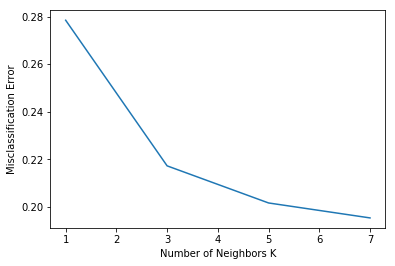

[0.80191911 0.80626449 0.80662309 0.80448436 0.80376759]


In [24]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
print(scores)

#### Decision Tree


In [20]:
#decision tree model
tree = DecisionTreeClassifier(random_state = 0) #maximum depth of 5 leaves
kbest = SelectKBest(f_classif) #select best 'k' features
impute = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0) #impute missing values: replacing NaNs with Median Column value for each column

#Pipeline for Logistic Regression with L2 'Ridge' Regularization
pipe_tree = Pipeline([('imputer', impute),
                       ('kbest', kbest),
                      ('dec_tree', tree)])
#parameters for grid search cross validation 
parameters = {'kbest__k': [5, 10, 20, 40, 60], #building models with 40, 60, 80, and 100 most significant variables
                 'dec_tree__max_depth' : [2,3,4,5]} #tuning tree depth for performance vs understanding

#grid search
grid_tree = GridSearchCV(pipe_tree, parameters, cv = 5, scoring = 'roc_auc') #run grid on parameters, 5-fold cross validation, AUC is evaluation metric

In [21]:
%%time
#fit models
grid_tree.fit(X_train,y_train)


C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\fe

Wall time: 7min


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000001D758DF30D0>)), ('dec_tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=N...         min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest__k': [5, 10, 20, 40, 60], 'dec_tree__max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [23]:
print("Best estimator:\n{}".format(grid_tree.best_estimator_)) #prints best model and pipeline
print("Decision Tree step:\n{}".format(grid_tree.best_estimator_.named_steps["dec_tree"])) #prints logistic regression step of pipeline
#print("Logistic Regression coefficients:\n{}".format(grid_tree.best_estimator_.named_steps["dec_tree"].coef_)) #prints coefficients of best estimator
print("Best Parameters: {}".format(grid_tree.best_params_)) #outputs best parameters settings
print("Best cross validation score: {:.2f}".format(grid_tree.best_score_)) #best produced cross validation score

Best estimator:
Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('kbest', SelectKBest(k=60, score_func=<function f_classif at 0x000001D758DF30D0>)), ('dec_tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None...         min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))])
Decision Tree step:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
Best Parameters: {'dec_tree__max_depth': 5, 'kbest__k': 60}
Best cross validation score: 0.80
